In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, LeakyReLU, Activation
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
(x_train, y_train), (x_test, y_test) = datasets.cifar10.load_data()

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

170498071/170498071 [==============================] - 13s 0us/step
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


In [3]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.3, random_state = 42)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((35000, 32, 32, 3), (15000, 32, 32, 3), (35000, 1), (15000, 1))

In [4]:
# Convert class vectors to binary class matrices. This is called one hot encoding.
num_classes = 10

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
print(y_train.shape, y_val.shape)

(35000, 10) (15000, 10)


In [5]:
# Normalize the data. Before we need to convert data type to float for computation.
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

In [6]:
print(x_train.shape)
print(y_train.shape)

(35000, 32, 32, 3)
(35000, 10)


In [8]:
def custom_leaky_relu(x):
    return LeakyReLU(0.1)(x)

model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(32, 32, 3)))
model.add(BatchNormalization())
model.add(Activation(custom_leaky_relu))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation(custom_leaky_relu))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3)))
model.add(BatchNormalization())
model.add(Activation(custom_leaky_relu))

model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation(custom_leaky_relu))

model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, (3, 3)))
model.add(BatchNormalization())
model.add(Activation(custom_leaky_relu))

model.add(Conv2D(512, (3, 3)))
model.add(BatchNormalization())
model.add(Activation(custom_leaky_relu))

model.add(Flatten())

model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation(custom_leaky_relu))
model.add(Dropout(0.5))

model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation(custom_leaky_relu))
model.add(Dropout(0.5))

model.add(Dense(10, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 batch_normalization_8 (Batc  (None, 30, 30, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_8 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 28, 28, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 28, 28, 64)       

In [9]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    validation_split=0.3
)

datagen.fit(x_train)


history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128, subset='training'),
    epochs=60,
    validation_data=datagen.flow(x_train, y_train, batch_size=128)
)

Epoch 1/60
192/192 [==============================] - 53s 192ms/step - loss: 1.8701 - accuracy: 0.3465 - val_loss: 4.1077 - val_accuracy: 0.1012
Epoch 2/60
192/192 [==============================] - 35s 182ms/step - loss: 1.3934 - accuracy: 0.5008 - val_loss: 2.6468 - val_accuracy: 0.2356
Epoch 3/60
192/192 [==============================] - 35s 183ms/step - loss: 1.2027 - accuracy: 0.5716 - val_loss: 1.7284 - val_accuracy: 0.4293
Epoch 4/60
192/192 [==============================] - 35s 182ms/step - loss: 1.0810 - accuracy: 0.6184 - val_loss: 1.1705 - val_accuracy: 0.5905
Epoch 5/60
192/192 [==============================] - 35s 183ms/step - loss: 0.9873 - accuracy: 0.6560 - val_loss: 1.0123 - val_accuracy: 0.6443
Epoch 6/60
192/192 [==============================] - 35s 184ms/step - loss: 0.9174 - accuracy: 0.6798 - val_loss: 0.9612 - val_accuracy: 0.6599
Epoch 7/60
192/192 [==============================] - 35s 182ms/step - loss: 0.8655 - accuracy: 0.6983 - val_loss: 1.1176 - val_ac

In [11]:
test_eval = model.evaluate(x_test, y_test, verbose=2)

print('Test loss: {:.2f}%'.format(test_eval[0]))
print('Test accuracy:{:.2f}%'.format(test_eval[1]))

313/313 - 2s - loss: 0.5529 - accuracy: 0.8370 - 2s/epoch - 5ms/step
Test loss: 0.55%
Test accuracy:0.84%


In [12]:
train_eval = model.evaluate(x_train, y_train, verbose=2)

print('Val loss:{:.2f}%'.format(train_eval[0]))
print('Val accuracy:{:.2f}%'.format(train_eval[1]))

1094/1094 - 5s - loss: 0.2670 - accuracy: 0.9128 - 5s/epoch - 4ms/step
Val loss:0.27%
Val accuracy:0.91%


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


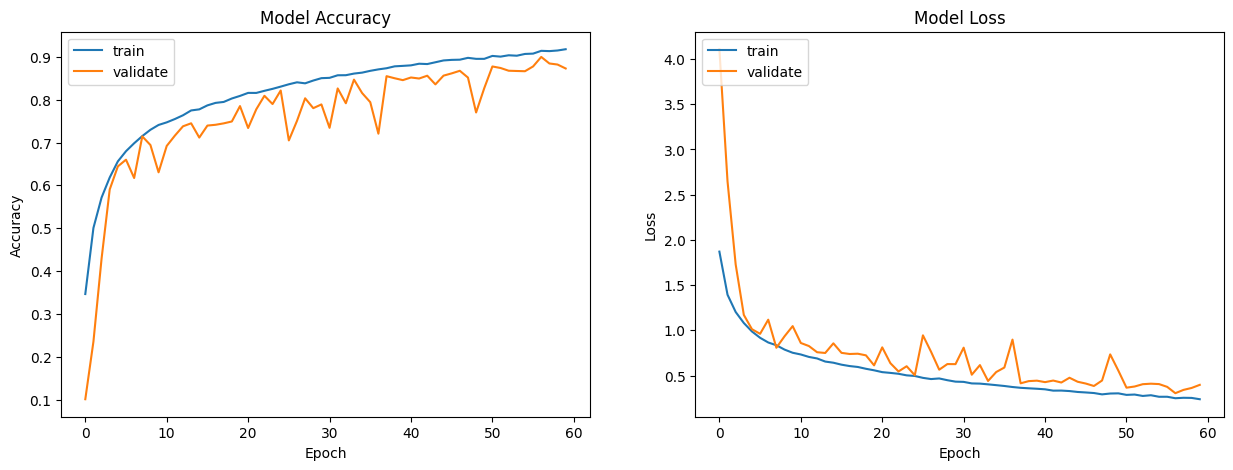

In [13]:
def plotmodelhistory(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

# list all data in history
print(history.history.keys())

plotmodelhistory(history)